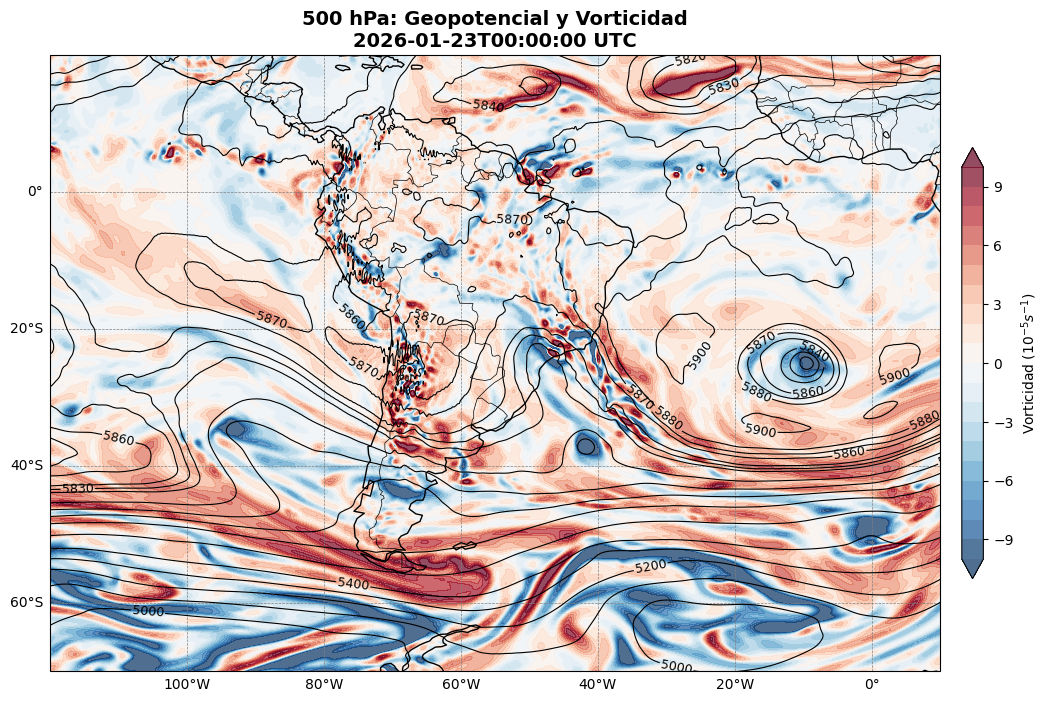

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar datos
dg = xr.open_dataset(r"D:\sinop\parcial.nc")
if 'expver' in dg.dims: 
    dg = dg.sel(expver=1).combine_first(dg.sel(expver=5))

# 2. Selección de nivel 500 hPa y fecha
fecha_query = '2026-01-23T00:00:00'
ds = dg.sel(pressure_level=500, valid_time=fecha_query, method='nearest')

# --- CÁLCULOS ---
z_gpm = ds.z / 9.80665

# Vorticidad: Priorizar variable nativa para ahorrar tiempo

# Cálculo manual optimizado
dy = 111000.0 
dx = 111000.0 * np.cos(np.deg2rad(ds.latitude))
vorticity = ((ds.v.differentiate("longitude") / dx) - (ds.u.differentiate("latitude") / dy)) * 1e5

# --- NIVELES PERSONALIZADOS (Sur vs Norte) ---
# Limpiamos el sur (30S-70S) y detallamos el norte (Ecuador-30S)
niveles_isohipsas = [
    5000, 5100, 5200, 5300, 5400, 5550, 5650, 5700, 5740, 5780, 
    5820, 5830, 5840, 5860, 5870, 5880, 5900, 5920, 5940
]
niveles_vort = np.linspace(-10, 10, 21)

# Punto cíclico
z_cyc, lon_cyc = add_cyclic_point(z_gpm.values, coord=ds.longitude)
vort_cyc, _ = add_cyclic_point(vorticity.values, coord=ds.longitude)

# 3. Graficación
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# Capa 1: Vorticidad (Sombreado)
im = ax.contourf(lon_cyc, ds.latitude, vort_cyc, levels=niveles_vort, 
                 cmap="RdBu_r", extend='both', transform=ccrs.PlateCarree(), alpha=0.7)

# Capa 2: Isohipsas (Líneas)
cs = ax.contour(lon_cyc, ds.latitude, z_cyc, levels=niveles_isohipsas, 
                colors="black", linewidths=0.8, transform=ccrs.PlateCarree(), zorder=3)

ax.clabel(cs, fmt="%d", inline=True, fontsize=9)

# Detalles geográficos
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=4)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=4)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.top_labels = gl.right_labels = False

# Estética
plt.colorbar(im, label='Vorticidad ($10^{-5} s^{-1}$)', pad=0.02, shrink=0.7)
ax.set_title(f"500 hPa: Geopotencial y Vorticidad\n{fecha_query} UTC", fontweight='bold', fontsize=14)

plt.show()

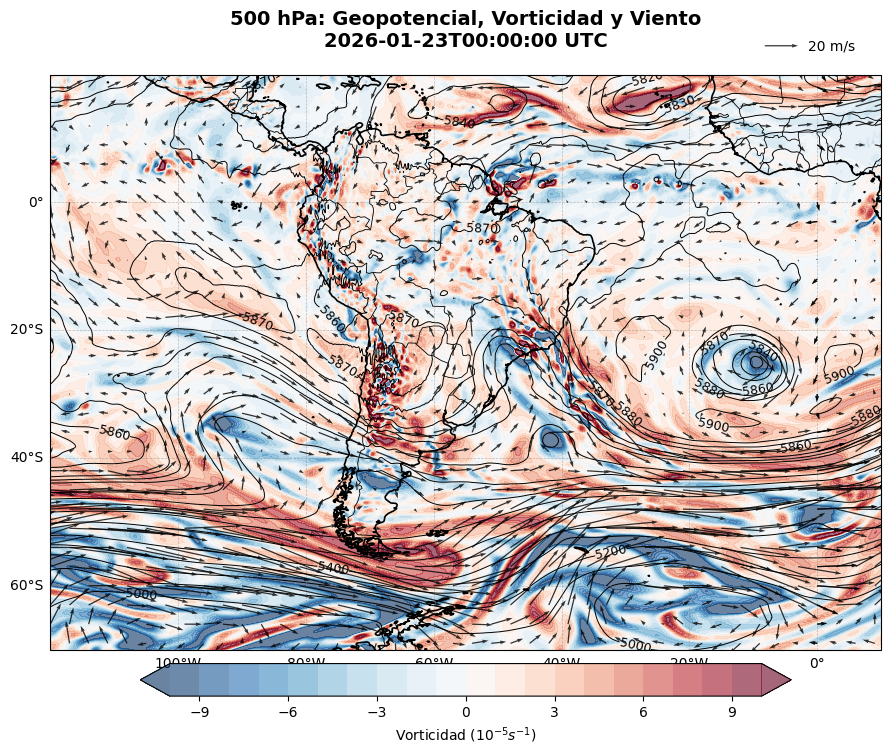

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar datos
dg = xr.open_dataset(r"D:\sinop\parcial.nc")
if 'expver' in dg.dims: 
    dg = dg.sel(expver=1).combine_first(dg.sel(expver=5))

# 2. Selección de nivel 500 hPa y fecha
fecha_query = '2026-01-23T00:00:00'
ds = dg.sel(pressure_level=500, valid_time=fecha_query, method='nearest')

# --- CÁLCULOS ---
z_gpm = ds.z / 9.80665
vorticity = ds.vo * 1e5

# --- MANEJO DE PUNTO CÍCLICO ---
# Para que no queden huecos en la longitud 0/360
z_cyc, lon_cyc = add_cyclic_point(z_gpm.values, coord=ds.longitude)
vort_cyc, _ = add_cyclic_point(vorticity.values, coord=ds.longitude)
u_cyc, _ = add_cyclic_point(ds.u.values, coord=ds.longitude)
v_cyc, _ = add_cyclic_point(ds.v.values, coord=ds.longitude)

# 3. Graficación
fig = plt.figure(figsize=(14, 9), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# Capa 1: Vorticidad (Sombreado HD)
im = ax.contourf(lon_cyc, ds.latitude, vort_cyc, levels=np.linspace(-10, 10, 21), 
                 cmap="RdBu_r", extend='both', transform=ccrs.PlateCarree(), alpha=0.6)

# Capa 2: Isohipsas (Líneas)
niveles_isohipsas = [5000, 5100, 5200, 5300, 5400, 5550, 5650, 5700, 5740, 5780, 
                    5820, 5830, 5840, 5860, 5870, 5880, 5900, 5920, 5940]
cs = ax.contour(lon_cyc, ds.latitude, z_cyc, levels=niveles_isohipsas, 
                colors="black", linewidths=0.7, transform=ccrs.PlateCarree())
ax.clabel(cs, fmt="%d", inline=True, fontsize=9)

# --- CAPA 3: FLECHAS DE VIENTO (QUIVER) ---
# Definimos un salto (skip) para no saturar el mapa
skip = (slice(None, None,12), slice(None, None, 12))# Toma 1 de cada 4 puntos

q = ax.quiver(lon_cyc[skip[1]], ds.latitude[skip[0]], 
              u_cyc[skip], v_cyc[skip],
              color='black',
              scale=500,        # Ajusta este valor si las flechas son muy largas
              width=0.0015,     # Grosor de la flecha
              headwidth=3, 
              transform=ccrs.PlateCarree(), 
              zorder=5, 
              alpha=0.8)

# Leyenda de la flecha (Referencia de velocidad)
ax.quiverkey(q, X=0.9, Y=1.05, U=20, label='20 m/s', labelpos='E', coordinates='axes')

# Detalles geográficos
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2)
ax.add_feature(cfeature.BORDERS, linewidth=0.6, linestyle='-')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False

# Colorbar y Título
plt.colorbar(im, label='Vorticidad ($10^{-5} s^{-1}$)', pad=0.02, shrink=0.6, orientation='horizontal')
ax.set_title(f"500 hPa: Geopotencial, Vorticidad y Viento\n{fecha_query} UTC", 
             fontweight='bold', fontsize=14, pad=20)

plt.show()

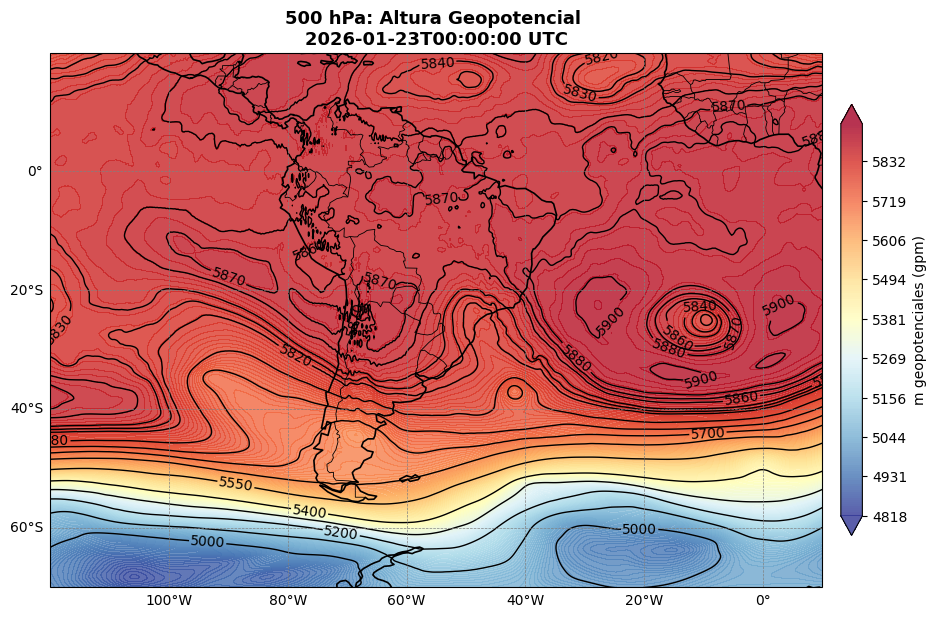

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar y limpiar datos
dg = xr.open_dataset(r"D:\sinop\nc\tareasinop.nc")
# --- CONFIGURACIÓN 500 HPa LIMPIO ---
fecha_query = '2026-01-23T00:00:00'
ds = dg.sel(pressure_level=500, valid_time=fecha_query, method='nearest')

# Cálculos
z_gpm = ds.z / 9.80665

# --- LÍMITES AUTOMÁTICOS ---
z_min, z_max = float(z_gpm.min()), float(z_gpm.max())

# 1. Niveles para el sombreado (Fondo liso, muchos niveles pero sin bordes)
niveles_sombreado = np.linspace(z_min, z_max, 200)

# 2. Niveles para las ISOHIPSAS (Líneas negras cada 60 gpm, estándar para 500hPa)
niveles_isohipsas = [
    5000, 5100, 5200, 5300, 5400, 5550, 5650, 5700, 5740, 5780, 
    5820, 5830, 5840, 5860, 5870, 5880, 5900, 5920, 5940
]


# Punto cíclico
z_cyc, lon_cyc = add_cyclic_point(z_gpm.values, coord=ds.longitude)

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# --- CAPA 1: SOMBREADO (Sin líneas de colores raras) ---
im = ax.contourf(lon_cyc, ds.latitude, z_cyc, levels=niveles_sombreado, 
                 cmap="RdYlBu_r", extend='both', transform=ccrs.PlateCarree(), 
                 alpha=0.8) # <--- Linewidths=0 elimina el ruido
# --- CAPA 1: SOMBREADO (Altura Geopotencial) ---

# --- CAPA 2: ISOHIPSAS (Líneas de contorno negras) ---
cs = ax.contour(lon_cyc, ds.latitude, z_cyc, levels=niveles_isohipsas, 
                colors="black", linewidths=1, transform=ccrs.PlateCarree(), zorder=2)

# Etiquetas de las isohipsas (clabel sin fontweight para evitar errores)
ax.clabel(cs, fmt="%d", inline=True, fontsize=10, inline_spacing=5)

# Geografía y Grillas
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, edgecolor='black', zorder=5)
ax.add_feature(cfeature.BORDERS, linewidth=0.6, zorder=5)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.top_labels = gl.right_labels = False

# Estética final
plt.colorbar(im, label='m geopotenciales (gpm)', pad=0.02, shrink=0.8)
ax.set_title(f"500 hPa: Altura Geopotencial \n{fecha_query} UTC", 
             fontweight='bold', fontsize=13)

plt.show()